In [ ]:
# Mount Google Drive to this Notebook instance.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd

train = pd.read_csv('./drive/My Drive/Datasets/titanic/train.csv')
test = pd.read_csv('./drive/My Drive/Datasets/titanic/test.csv')
print(train.sample(10))
print(test.sample(10))

     PassengerId  Survived  Pclass  ...     Fare Cabin  Embarked
28            29         1       3  ...   7.8792   NaN         Q
489          490         1       3  ...  15.9000   NaN         S
738          739         0       3  ...   7.8958   NaN         S
308          309         0       2  ...  24.0000   NaN         C
478          479         0       3  ...   7.5208   NaN         S
436          437         0       3  ...  34.3750   NaN         S
551          552         0       2  ...  26.0000   NaN         S
636          637         0       3  ...   7.9250   NaN         S
40            41         0       3  ...   9.4750   NaN         S
140          141         0       3  ...  15.2458   NaN         C

[10 rows x 12 columns]
     PassengerId  Pclass  ... Cabin Embarked
335         1227       1  ...  C106        S
65           957       2  ...   NaN        S
313         1205       3  ...   NaN        Q
98           990       3  ...   NaN        S
26           918       1  ...   B36 

      Sex  Survived
0  female  0.742038
1    male  0.188908
     PassengerId  Survived  Pclass  ...   Fare        Cabin  Embarked
27            28         0       1  ...  263.0  C23 C25 C27         S
88            89         1       1  ...  263.0  C23 C25 C27         S
341          342         1       1  ...  263.0  C23 C25 C27         S

[3 rows x 12 columns]


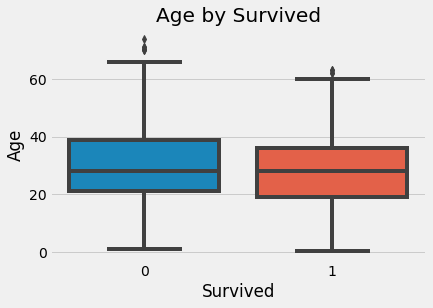

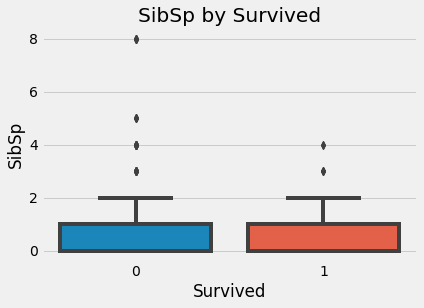

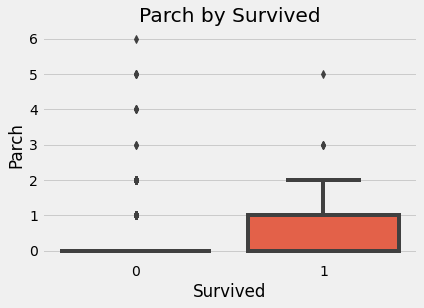

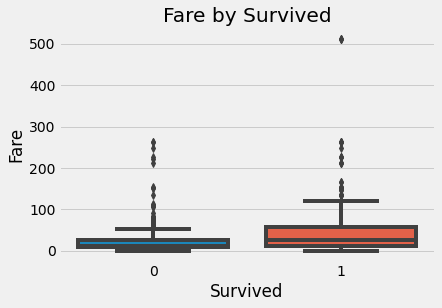

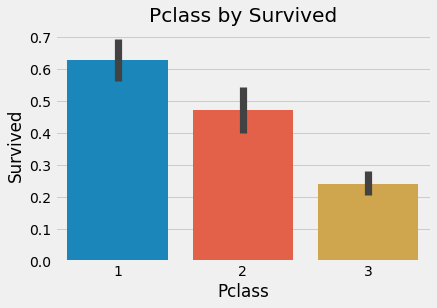

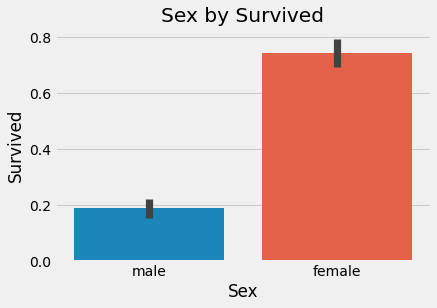

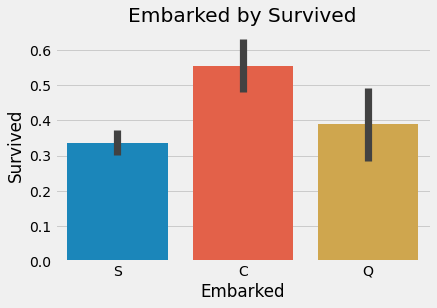

In [ ]:
import seaborn as sns
pd.set_option('display.max_rows', 1000)
import matplotlib.pyplot as plt
import math
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.metrics import confusion_matrix, roc_auc_score ,roc_curve,auc
from sklearn.model_selection import GridSearchCV,StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from collections import Counter
%pip install ppscore # installing ppscore, library used to check non-linear relationships between our variables
import ppscore as pps # importing ppscore
import string
import numpy as np

seed =45

plt.style.use('fivethirtyeight')

def basic_analysis(df1, df2):
    '''the function compares the average values of  2 dataframes'''
    b = pd.DataFrame()
    b['First df_mean'] = round(df1.mean(),2)
    b['Second df_mean'] = round(df2.mean(),2)
    c = (b['First df_mean']/b['Second df_mean'])
    if [c<=1]:
        b['Variation, %'] = round((1-((b['First df_mean']/b['Second df_mean'])))*100)
    else:
        b['Variation, %'] = round(((b['First df_mean']/b['Second df_mean'])-1)*100)
        
    b['Influence'] = np.where(abs(b['Variation, %']) <= 9, "feature's effect on the target is not defined", 
                              "feature value affects the target")

    return b

## thanks to @Nadezda Demidova  https://www.kaggle.com/demidova/titanic-eda-tutorial-with-seaborn
train.loc[train['PassengerId'] == 631, 'Age'] = 48

# Passengers with wrong number of siblings and parch
train.loc[train['PassengerId'] == 69, ['SibSp', 'Parch']] = [0,0]
test.loc[test['PassengerId'] == 1106, ['SibSp', 'Parch']] = [0,0]

## checking for Survived dependence of Sex feature
survived_by_sex = train[["Sex", "Survived"]].groupby(['Sex'], as_index=False).mean().sort_values(by='Survived', ascending=False)
print(survived_by_sex)

# Outlier detection and df cleaning from them
## thanks to https://www.kaggle.com/yassineghouzam/titanic-top-4-with-ensemble-modeling

def detect_outliers(df,n,features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method.
    """
    outlier_indices = []
    
    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.7 * IQR                #### increased to 1.7
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    
    return multiple_outliers   

# detect outliers from Age, SibSp , Parch and Fare
Outliers_to_drop = detect_outliers(train,2,["Age","SibSp","Parch","Fare"])
print(train.loc[Outliers_to_drop] )# Show the outliers rows

## distribution and checking for outliers in numeric features
import matplotlib.pyplot as plt
features = train[['Age', 'SibSp', 'Parch', 'Fare']].columns
for i in features:
    sns.boxplot(x="Survived",y=i,data=train)
    plt.title(i+" by "+"Survived")
    plt.show()

## distribution of cat features
cat_features = train[['Pclass', 'Sex', 'Embarked']].columns
for i in cat_features:
    sns.barplot(y="Survived",x=i,data=train)
    plt.title(i+" by "+"Survived")
    plt.show()



             First df_mean  ...                                      Influence
PassengerId         444.37  ...  feature's effect on the target is not defined
Survived              1.00  ...               feature value affects the target
Pclass                1.95  ...               feature value affects the target
Age                  28.23  ...  feature's effect on the target is not defined
SibSp                 0.46  ...               feature value affects the target
Parch                 0.46  ...               feature value affects the target
Fare                 48.40  ...               feature value affects the target

[7 rows x 4 columns]


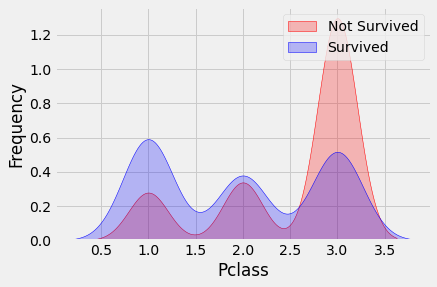

In [ ]:
## Concatenate test and train datasets while not including id and target(Survived) features
df = pd.concat((train.loc[:,'Pclass':'Embarked'], test.loc[:,'Pclass':'Embarked'])).reset_index(drop=True)
#Difference between survived and not survived means....
survived = train.drop(train[train['Survived']!=1].index)
not_survived = train.drop(train[train['Survived']!=0].index)
print(basic_analysis(survived, not_survived))

#doing the same but in plots
def mean_plot(attribute):
  g = sns.kdeplot(train[attribute][(train["Survived"] == 0) & (train[attribute].notnull())], color="Red", shade = True)
  g = sns.kdeplot(train[attribute][(train["Survived"] == 1) & (train[attribute].notnull())], ax =g, color="Blue", shade= True)
  g.set_xlabel(attribute)
  g.set_ylabel("Frequency")
  g = g.legend(["Not Survived","Survived"])

mean_plot('Pclass')


#

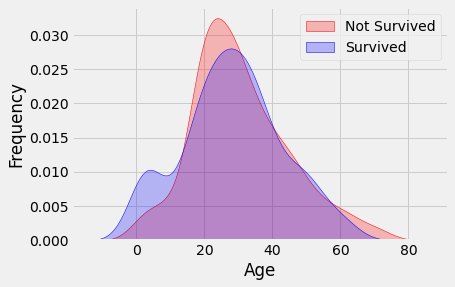

In [ ]:
mean_plot('Age')


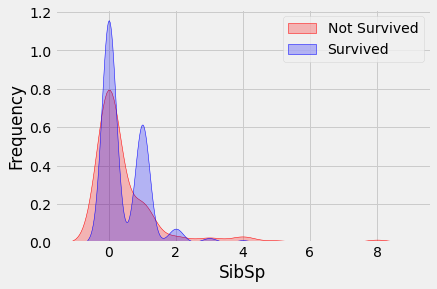

In [ ]:
mean_plot('SibSp')


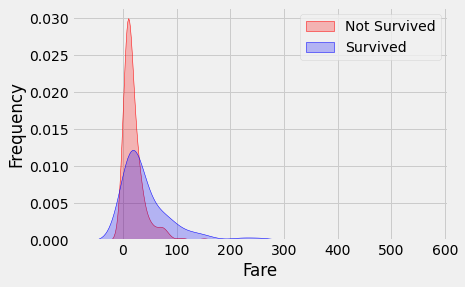

In [ ]:
mean_plot('Fare')

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in 

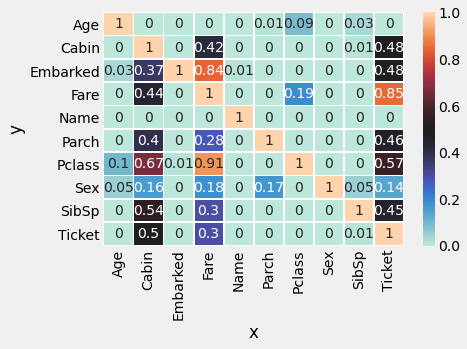

In [ ]:
## PPS matrix to analyze the relation among the features

matrix_pps = pps.matrix(df)[['x', 'y', 'ppscore']].pivot(columns='x', index='y', values='ppscore')
matrix_pps = matrix_pps.apply(lambda x: round(x, 2))

sns.heatmap(matrix_pps, vmin=0, vmax=1, cmap="icefire", linewidths=0.75, annot=True)

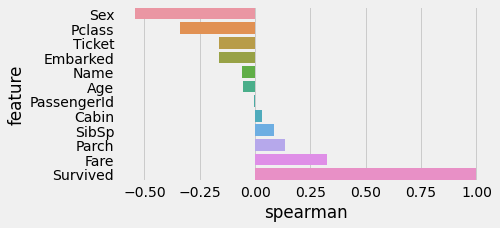

In [ ]:
#Correlation with Survived for other variables
def spearman(frame, features):
  spr = pd.DataFrame()
  spr['feature'] =features
  spr['spearman'] = [frame[f].corr(frame['Survived'], 'spearman') for f in features]
  spr = spr.sort_values('spearman')
  plt.figure(figsize=(6, 0.25*len(features)))
  sns.barplot(data=spr, y='feature', x='spearman', orient='h')
features = train.columns
spearman(train, features)




In [ ]:
#checking out the null values of attributes
def null_details(df):
  b= pd.DataFrame()
  b['Missing Values, %'] = round(df.isnull().sum()/df.shape[0]*100)
  b['N Unique Values'] = df.nunique()
  b['dtype'] = df.dtypes
  return b
null_frame = null_details(df)
print(null_frame)


          Missing Values, %  N Unique Values    dtype
Pclass                  0.0                3    int64
Name                    0.0             1307   object
Sex                     0.0                2   object
Age                    20.0               97  float64
SibSp                   0.0                7    int64
Parch                   0.0                8    int64
Ticket                  0.0              929   object
Fare                    0.0              281  float64
Cabin                  77.0              186   object
Embarked                0.0                3   object


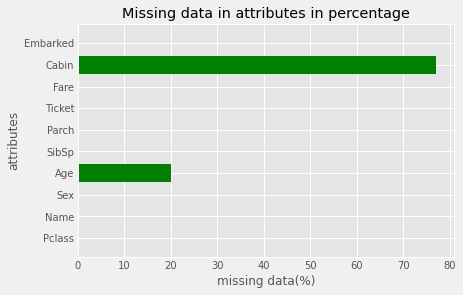

In [ ]:
def drawBarChart(dataFrame, xLabel, yLabel, title): 
    fig = plt.figure()

    plt.style.use('ggplot')

    x = list(dataFrame.index)
    

    x_pos = [i for i, _ in enumerate(x)]

    plt.barh(x_pos, dataFrame, color='green')
    plt.xlabel(xLabel)
    plt.ylabel(yLabel)
    plt.title(title)

    plt.yticks(x_pos, x)

    plt.show()

drawBarChart(null_frame['Missing Values, %'], 'missing data(%)','attributes',  'Missing data in attributes in percentage')

In [ ]:
## for Age imputation, we check its dependence on Pclass
age_by_pclass = pd.DataFrame(df.groupby('Pclass')['Age'].describe())




In [ ]:
#Age Tuning
df['Age'] =df.groupby(['Pclass'])['Age'].transform(lambda x:x.fillna(x.median()))
df['Age'] = df['Age'].astype(int)
df['Age_cat'] = pd.qcut(df['Age'], q=[0, .16, .33, .49, .66, .83, 1], labels=False, precision=1)

#Add Title Feature and remove Name attribute
df['Title'] = df.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
df['Title'] = df['Title'].replace(['Lady', 'Countess','Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
df['Title'] = df['Title'].replace('Mlle', 'Miss')
df['Title'] = df['Title'].replace('Ms', 'Miss')
df['Title'] = df['Title'].replace('Mme', 'Mrs')
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
df['Title'] = df['Title'].map(title_mapping)
df['Title'] = df['Title'].fillna(0)

##dropping Name feature
df = df.drop(['Name'], axis=1)

# 'Sex' to integer
df["Sex"][df["Sex"] == "male"] = 0
df["Sex"][df["Sex"] == "female"] = 1
df["Sex"] = df["Sex"].astype(int)


# Ticket tuning
tickets = []
for i in list(df.Ticket):
    if not i.isdigit():
        tickets.append(i.replace(".","").replace("/","").strip().split(" ")[0])
    else:
        tickets.append("x")
df["Ticket"] = tickets
df['Ticket_Frequency'] = df.groupby('Ticket')['Ticket'].transform('count')
df = pd.get_dummies(df, columns= ["Ticket"], prefix = "T")


## Fare tuning:
df['Fare'] = df.groupby("Pclass")['Fare'].transform(lambda x: x.fillna(x.median())) 

df['Zero_Fare'] = df['Fare'].map(lambda x: 1 if x == 0 else (0))


def fare_category(fr): 
    if fr <= 7.91:
        return 1
    elif fr <= 14.454 and fr > 7.91:
        return 2
    elif fr <= 31 and fr > 14.454:
        return 3
    return 4

df['Fare_cat'] = df['Fare'].apply(fare_category) 

# Replace missing values with 'U' for Cabin
df['Cabin'] = df['Cabin'].fillna('U')
import re
# Extract first letter
df['Cabin'] = df['Cabin'].map(lambda x: re.compile("([a-zA-Z]+)").search(x).group())
cabin_category = {'A':9, 'B':8, 'C':7, 'D':6, 'E':5, 'F':4, 'G':3, 'T':2, 'U':1}
# Mapping 'Cabin' to group
df['Cabin'] = df['Cabin'].map(cabin_category)


df["Embarked"] = df["Embarked"].fillna("C")
df["Embarked"][df["Embarked"] == "S"] = 1
df["Embarked"][df["Embarked"] == "C"] = 2
df["Embarked"][df["Embarked"] == "Q"] = 3
df["Embarked"] = df["Embarked"].astype(int)

# New 'familySize' feature
df['FamilySize'] = df['SibSp'] + df['Parch'] + 1


df['FamilySize_cat'] = df['FamilySize'].map(lambda x: 1 if x == 1 else (2 if 5 > x >= 2 else (3 if 8 > x >= 5 else 4 )))       

df['Alone'] = [1 if i == 1 else 0 for i in df['FamilySize']]




dummy_col=['Title', 'Sex',  'Age_cat', 'SibSp', 'Parch', 'Fare_cat', 'Embarked', 'Pclass', 'FamilySize_cat']
dummy = pd.get_dummies(df[dummy_col], columns=dummy_col, drop_first=False)
df = pd.concat([dummy, df], axis = 1)


dummy_fare = ['Fare']
dummy_f = pd.get_dummies(df[dummy_fare], columns=dummy_fare, drop_first=True)
df = pd.concat([dummy_f, df], axis = 1)

## some little dance with features
df['FareCat_Sex'] = df['Fare_cat']*df['Sex']
df['Pcl_Sex'] = df['Pclass']*df['Sex']
df['Pcl_Title'] = df['Pclass']*df['Title']
df['Age_cat_Sex'] = df['Age_cat']*df['Sex']
df['Age_cat_Pclass'] = df['Age_cat']*df['Pclass']
df['Title_Sex'] = df['Title']*df['Sex']

df['SmallF'] = df['FamilySize'].map(lambda s: 1 if  s == 2  else 0)
df['MedF']   = df['FamilySize'].map(lambda s: 1 if 3 <= s <= 4 else 0)
df['LargeF'] = df['FamilySize'].map(lambda s: 1 if s >= 5 else 0)
df['Senior'] = df['Age'].map(lambda s:1 if s>70 else 0)

df["Fare"] = df["Fare"].map(lambda i: np.log(i) if i > 0 else 0)



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:66: SettingWithCopyWarning: 
A value is trying to b

In [ ]:
df.shape

(1309, 385)

In [ ]:
df.columns

Index(['Fare_3.1708', 'Fare_4.0125', 'Fare_5.0', 'Fare_6.2375', 'Fare_6.4375',
       'Fare_6.45', 'Fare_6.4958', 'Fare_6.75', 'Fare_6.8583', 'Fare_6.95',
       ...
       'FareCat_Sex', 'Pcl_Sex', 'Pcl_Title', 'Age_cat_Sex', 'Age_cat_Pclass',
       'Title_Sex', 'SmallF', 'MedF', 'LargeF', 'Senior'],
      dtype='object', length=385)

In [ ]:
def reduce_memory_usage(df):
    """ The function will reduce memory of dataframe
    Note: Apply this function after removing missing value"""
    intial_memory = df.memory_usage().sum()/1024**2
    print('Intial memory usage:',intial_memory,'MB')
    for col in df.columns:
        mn = df[col].min()
        mx = df[col].max()
        if df[col].dtype != object:            
            if df[col].dtype == int:
                if mn >=0:
                    if mx < np.iinfo(np.uint8).max:
                        df[col] = df[col].astype(np.uint8)
                    elif mx < np.iinfo(np.uint16).max:
                        df[col] = df[col].astype(np.uint16)
                    elif mx < np.iinfo(np.uint32).max:
                        df[col] = df[col].astype(np.uint32)
                    elif mx < np.iinfo(np.uint64).max:
                        df[col] = df[col].astype(np.uint64)
                else:
                    if mn > np.iinfo(np.int8).min and mx < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif mn > np.iinfo(np.int16).min and mx < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif mn > np.iinfo(np.int32).min and mx < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif mn > np.iinfo(np.int64).min and mx < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)
            if df[col].dtype == float:
                df[col] =df[col].astype(np.float32)
    
    red_memory = df.memory_usage().sum()/1024**2
    print('Memory usage after complition: ',red_memory,'MB')
    
reduce_memory_usage(df)

Intial memory usage: 0.707942008972168 MB
Memory usage after complition:  0.4857339859008789 MB


In [ ]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import RandomOverSampler

X_train = df[:train.shape[0]]
X_test_fin = df[train.shape[0]:]
y = train.Survived
X_train['Y'] = y
df = X_train
df.head(20)
X = df.drop('Y', axis =1)
y = df.Y

ros = RandomOverSampler(random_state=42)
X_ros, y_ros = ros.fit_resample(X,y)
x_train, x_valid, y_train, y_valid = train_test_split(X_ros,y_ros,test_size = 0.2,  random_state=10)

sc = MinMaxScaler(feature_range=(-1,1))
x_train = sc.fit_transform(x_train)
x_valid = sc.fit_transform(x_valid)
d_train = xgb.DMatrix(x_train, label=y_train)
d_valid = xgb.DMatrix(x_valid, label=y_valid)
d_test = xgb.DMatrix(X_test_fin)

params = {
        'objective':'binary:hinge',
        'max_depth':13,
        'learning_rate':0.03,
        'eval_metric':'auc',
        'min_child_weight':1,
        'subsample':0.64,
        'colsample_bytree':0.4,
        'seed':29,
        'reg_lambda':2.79,
        'reg_alpha':0.1,
        'gamma':0,
        'scale_pos_weight':1.68,
        'n_estimators': 600,
        'nthread':-1
}
watchlist = [(d_train, 'train'), (d_valid,'valid')]
nrounds = 10000
model = xgb.train(params, d_train, nrounds, watchlist, early_stopping_rounds=350, maximize=True, verbose_eval=10)


watchlist = [(d_train, 'train'), (d_valid, 'valid')]
nrounds=10000  
model = xgb.train(params, d_train, nrounds, watchlist, early_stopping_rounds=350, 
                           maximize=True, verbose_eval=10)


/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://p

[0]	train-auc:0.5	valid-auc:0.5
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 350 rounds.
[10]	train-auc:0.5	valid-auc:0.5
[20]	train-auc:0.624724	valid-auc:0.572917
[30]	train-auc:0.856961	valid-auc:0.817204
[40]	train-auc:0.874925	valid-auc:0.87164
[50]	train-auc:0.89318	valid-auc:0.873488
[60]	train-auc:0.906134	valid-auc:0.889113
[70]	train-auc:0.917985	valid-auc:0.894321
[80]	train-auc:0.925711	valid-auc:0.891465
[90]	train-auc:0.936894	valid-auc:0.892641
[100]	train-auc:0.937998	valid-auc:0.896673
[110]	train-auc:0.941309	valid-auc:0.886257
[120]	train-auc:0.944693	valid-auc:0.886257
[130]	train-auc:0.952928	valid-auc:0.886257
[140]	train-auc:0.954032	valid-auc:0.883905
[150]	train-auc:0.959696	valid-auc:0.885081
[160]	train-auc:0.959696	valid-auc:0.885081
[170]	train-auc:0.967859	valid-auc:0.87584
[180]	train-auc:0.968962	valid-auc:0.87584
[190]	train-auc:0.972419	valid-auc:0.881048
[200]	train

In [ ]:
accuracy = pd.DataFrame()
accuracy['predict'] = model.predict(d_valid)
accuracy['predict'] = accuracy['predict'].apply(lambda x: 1 if x>0.8 else 0)
#accuracy_score(y_valid, accuracy['predict'])

from sklearn import metrics

y_pred = model.predict(d_valid)
print('Accuracy :{0:0.5f}'.format(metrics.accuracy_score(y_valid, y_pred))) 
print('AUC : {0:0.5f}'.format(metrics.roc_auc_score(y_valid, y_pred)))
print('Precision : {0:0.5f}'.format(metrics.precision_score(y_valid, y_pred)))
print('Recall : {0:0.5f}'.format(metrics.recall_score(y_valid, y_pred)))
print('F1 : {0:0.5f}'.format(metrics.f1_score(y_valid, y_pred)))



Accuracy :0.88636
AUC : 0.88273
Precision : 0.88976
Recall : 0.91129
F1 : 0.90040


In [ ]:
sub = pd.DataFrame()
sub['PassengerId'] = test['PassengerId']
sub['Survived'] = model.predict(d_test)
sub['Survived'] = sub['Survived'].apply(lambda x: 1 if x>0.8 else 0)
# sub['Survived'] = sub.apply(lambda r: leaks[int(r['PassengerId'])] if int(r['PassengerId']) in leaks else r['Survived'], axis=1)
sub.to_csv('submission.csv', index=False)

sub.head()

ValueError: ignored